# Setup

In [58]:
!pip install ale-py
!pip install gymnasium

from ale_py import ALEInterface
ale = ALEInterface()
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

import gymnasium as gym
import gymnasium.utils.seeding as seeding
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tempfile
import torch

from IPython.display import Image
from collections import deque
from gymnasium.wrappers import RecordVideo
from moviepy.editor import VideoFileClip
from typing import NamedTuple

tempfile.tempdir = './'

# The device to use for PyTorch. Just defined here for convenience.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The default random seed used in the lectures.
DEFAULT_RANDOM_SEED=10

def init_random(env: gym.Env=None, seed=DEFAULT_RANDOM_SEED):
    """Initializes all the random generators used by frameworks to a default value.

    If `env` is specified, it sets also the env random generator and return the env itself. That is
    just a convenient setup for the notebooks, even if arguably not the best structured code setup.
    """
    try:
      random.seed(seed)
      np.random.seed(seed)
      torch.manual_seed(seed)
      # torch.use_deterministic_algorithms(True)
      if env is not None:
          env.np_random, _ = seeding.np_random(seed)
          env.reset(seed=seed)
    except Exception as e:
        print(e)
    return env

def epsilon_gen(eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
    """Generator function for Ɛ and its decay (e.g., exploration via Ɛ-greedy policy)."""
    eps = eps_start
    while True:
        yield eps
        eps = max(eps * eps_decay, eps_min)

def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
    """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_src)."""
    for dest_param, src_param in zip(dest.parameters(), src.parameters()):
        dest_param.data.copy_(tau * src_param.data + (1.0 - tau) * dest_param.data)

class Experience(NamedTuple):
    """A single step / experience of an agent stored in the replay buffer."""
    state:      np.array
    action:     float
    reward:     float
    next_state: np.array
    done:       bool

class ReplayBuffer:
    """Simple replay buffer for off-policy deep reinforcement learning algorithms.

    IMPORTANT: This ReplayBuffer is specifically tuned for the DDPG / TD3 / SAC algorithms in these
    lectures. In particular, the action space is a single float scalar. If you want to adapt those
    algorithms to different environments, you will need to update this code accordingly as well.
    """
    def __init__(self, buffer_size=int(1e5)):
        """Initializes the buffer with an internal deque of size `buffer_size`."""
        self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        """Stores a single step / experience of an agent."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size: int = 128):
        """Randomly selects `batch_size` items from the buffer, stacks them, and returns them."""
        all_indices = np.arange(len(self.memory))
        selection = np.random.choice(all_indices, size=batch_size)
        return self.unpack(selection)

    def unpack(self, selection):
        """Given the `selection` of experiences, returns them as a tuple of stacked values.

        This is convenient for the usage in the various learning algorithms so that they don't have
        to do it themselves.
        """
        experiences = [e for i in selection if (e := self.memory[i]) is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states      = torch.from_numpy(np.stack(states)).float().to(DEVICE)
        actions     = torch.from_numpy(np.vstack(actions)).float().to(DEVICE) # NOTE: float scalar!
        rewards     = torch.from_numpy(np.vstack(rewards)).float().to(DEVICE)
        next_states = torch.from_numpy(np.stack(next_states)).float().to(DEVICE)
        dones       = torch.from_numpy(np.vstack(dones, dtype=np.uint8)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

def show_gym_video_recording(name_prefix: str = 'rl-video', folder: str = None):
    """Shows the recorded video of episode 0 of a gym environment."""
    if folder == None:
        folder = tempfile.tempdir
    video_file = os.path.join(folder, f'{name_prefix}-episode-0.mp4')
    video_clip = VideoFileClip(video_file)
    gif_file = os.path.join('./', 'rl-video.gif')
    video_clip.write_gif(gif_file, fps=15)
    video_clip.close()
    return Image(open(gif_file, 'rb').read())

def plot_scores(scores, rolling_window=25):
    """Plots training scores and their running average."""
    avgs = pd.Series(scores).rolling(rolling_window).mean()
    x = np.arange(len(scores))
    plt.figure('Episode scores')
    plt.plot(x, scores, label='Scores')
    plt.plot(x, avgs, 'r', label='Running average')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    return plt.show()

def gym_simulation(env_name: str, agent=None, max_t=1_000, env_kwargs={}):
    """Runs a simulation of an agent in an initialized gym environment and plays the video."""
    sim_env = gym.make(env_name, render_mode="rgb_array_list", **env_kwargs)
    sim_env = init_random(sim_env)
    sim_env = RecordVideo(sim_env, './', lambda i: i == 0)
    state, _ = sim_env.reset()
    for _ in range(max_t):
        action = agent.act(state) if agent is not None else sim_env.action_space.sample()
        next_state, _, terminated, truncated, _ = sim_env.step(action)
        if terminated or truncated:
            break
        state = next_state
    sim_env.close()
    return show_gym_video_recording()

# Policy Gradient Methods

Policy _based_ methods learn the optimal policy directly, without necessarily estimating a value
function. Policy _gradient_ methods do that performing gradient ascent on the objective function.

### Advantages

 * No need to store action-values.
 * Ability to learn a stochastic policy direcly.
 * Hence, no need to manually tune exploitation vs. exploration.
 * Effective in continuous action spaces (and high-dimensional state spaces).
 * They generally have good convergence properties.

### Disadvantages

 * They might have high-variance.
 * Might converge to a local maximum.
 * Slower than other methods, and might take a long time to train.

In [3]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from typing import Union

import gymnasium as gym

# from util.gymnastics import DEVICE, gym_simulation, init_random, plot_scores

## Cart Pole Environment

Explore the [Gymnasium Cart Pole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/),
and run the simulation below!

**IMPORTANT**: For this notebook, we are going to tweak the reward function of the environment. See
the "Reward Function" section.

  logger.warn(



MoviePy - Building file ./rl-video.gif with imageio.


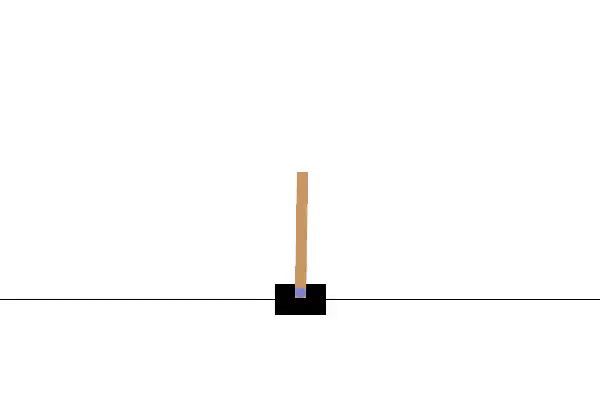

In [5]:
# `gym_simulation` is a convenient utility to run simulations on Gynmasium environment, so that we
# don't have to repeat the same code in all notebooks. But it works basically the same as the one we
# implemented for DQN :) Feel free to check the source code!

gym_simulation("CartPole-v1")

In [4]:
# Just for convenience, we hardcode the state and action sizes of the CartPole environment.
STATE_SIZE  = 4
ACTION_SIZE = 2

### Reward Function

The Cart Pole reward function returns `+1` reward at every timestep: the idea is that the longer the
pole stays in the upright position the better. Such reward function does not encapsulate whether an
action is good or bad, and it does not play well with some concepts we are going to analyze later
in this notebook (such as normalization and custom baselines).

For this reason, we "adjust" the reward taking into account angle and position of the pole as a
heuristic to evaluate how good is the next state (to which the agent transitioned given its action).

In [5]:
# This function works for both single and vectorized environments and rewards.
def adjust_reward(next_state, reward) -> Union[np.float64, np.array]:
    angle = next_state[2] if len(next_state.shape) == 1 else next_state[:, 2]
    position = next_state[0] if len(next_state.shape) == 1 else next_state[:, 0]
    return reward - (np.abs(angle) / 0.418) - (np.abs(position) / 4.8) # reward - normalized angle - normalized position : Makes sure its near the center all the time and the angle is not much

## Optimization Rule

For one trajectory $\tau$ (or episode), the neural networks weight can be updated according to:

$$
\theta_{k+1} = \theta_k - \alpha \sum_{t=0} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) R(\tau)
$$

We can interpret this as pushing up probabilities for action / states combinations when the return
is high, and the other way around for low returns.

This relationship is also interesting because only the policy function needs to be differentiable:
the reward function might very well be discontinuous and sparse.

For derivation, check the [Hugging Face Deep RL tutorial](https://huggingface.co/learn/deep-rl-course/unit4/pg-theorem).

## REINFORCE

<div style="width: 70%">
  <img src="https://github.com/pranay8297/drl-zh/blob/main/assets/04_PG_reinforce.png?raw=1">
  <br>
  <small>Sutton & Barto 2022</small>
</div>

In [6]:
# https://huggingface.co/learn/deep-rl-course/unit4/policy-gradient
# https://huggingface.co/learn/deep-rl-course/unit4/pg-theorem
class PolicyNetwork(nn.Module):
    def __init__(self, hidden_units=16):
        super(PolicyNetwork, self).__init__()
        # TODO: Create two fully connected / linear layers, input dimension STATE_SIZE, output
        #       dimension ACTION_SIZE, and hidden units specified in the constructor.
        self.layers = nn.Sequential(
            nn.Linear(STATE_SIZE, 16),
            nn.ReLU(),
            nn.Linear(16, ACTION_SIZE)
        )

    def forward(self, x):
        # TODO: Use ReLU as first non-linearity, and softmax for the output layer (so that we can
        #       interpret this as a stochastic policy across action probabilities). Hint: make sure
        #       to choose the right dimension for the softmax! Another hint: it should be the last
        #       dimension of the tensor (to be able to work with single and batched updates).
        # breakpoint()
        if len(x.shape) < 2:
            x = x[None, :] # batch the single sample
        acts = self.layers(x)
        return F.softmax(acts)

In [86]:
# Agent that will work with both single and vectorized environments, keep that in mind when thinking
# about dimensionality and how to operate on tensors in a consistent way!
class Agent:
    def __init__(self):
        self.policy = PolicyNetwork()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-2)

    def sample_action(self, state: np.array) -> tuple[np.array, torch.Tensor]: # BATCHED
        """Samples an action for a state from the policy network."""
        # TODO: Convert the state to a PyTorch tensor.
        state = torch.from_numpy(state).to(torch.float32)
        # TODO: Get the action probabilities from the policy.
        probs = self.policy(state) # bs, ACTION_SIZE
        # TODO: Create a Categorical distribution with those probabilities.
        cdist = Categorical(probs) # pdf
        # TODO: Sample the action from the categorical distribution, and gets its logprob.
        action = cdist.sample() # bs, 1
        logprob = cdist.log_prob(action) # bs, 1 # use the built in function
        # TODO: Return the action and convert it to be used by Gymnasium (hint: use cpu().numpy()).
        #       Also return the the log_prob for that action as well as second return output.
        return action.cpu().numpy(), logprob

    def learn(self, log_probs: list[torch.Tensor], returns: Union[np.float64, np.array]):
        """Perform a step of learning (gradient ascent) on the policy network."""
        # TODO: To handle both single and vectorized environments, rewards can be either a scalar or
        #       an array. Let's create a corresponding tensor first.
        # log_probs: bs, episode_length - torch.stack the list

        # TODO: Stack the log_probs (hint: use torch.stack)
        log_probs = torch.stack(log_probs)

        if len(log_probs.shape) > 1: # batched input
            # in case of batched input after stacking the shape will be eps_len, bs
            # so we have to transpose it
            log_probs = log_probs.T

        if not isinstance(returns, torch.Tensor):
            returns = torch.tensor(returns).to(torch.float32)

        # TODO: Compute the policy loss. Hint: gradient ascent.... so negative sign!

        if len(log_probs.shape) > 1: # batched input
            policy_loss = -1*(log_probs*returns).sum()
        else:
            policy_loss = -1*(log_probs*returns).sum(1).mean() # single value

        # TODO: Perform a backprop step via the optimizer.
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

    @torch.no_grad
    def act(self, state):
        """Convenient method for the agent to select an action during simulation."""
        action, _ = self.sample_action(state[np.newaxis, :])
        return action[0]

In [78]:
def REINFORCE(env: gym.Env, agent, max_episodes=10_000, max_t=1_000, gamma=0.9999):
    # Tracks the score for each episode.
    #
    # IMPORTANT: in this notebook we modified the reward function but effectively we still consider
    # the score as the original reward function. In fact, we just track the latest timestamp of the
    # episode (representing how long we were able to balance the pole). This is important to know to
    # properly read the "score" value and its meaning (which still encapsulates learning quality).
    scores = []
    # Loop for max_episodes.

    for i_episode in range(1, max_episodes + 1):
        # Store episode rewards.
        rewards = []
        # Store episode log probabilities.
        log_probs = []
        # Start the episode in the initial state.
        state, _ = env.reset()

        # TODO: Generate an episode following the policy, for T (max_t) timesteps.
        for t in range(max_t):
            # TODO: sample action and log probability.
            action, log_prob = agent.sample_action(state)
            # TODO: perform a step in the environment.
            state, reward, terminated, truncated, _ = env.step(action[0])
            # Storing the reward (adjusting it for the purpose of this notebook).

            # reward = adjust_reward(state, reward)
            rewards.append(adjust_reward(state, reward))

            # TODO: store reward and log probability.
            log_probs.append(log_prob[0])

            # TODO: Check for episode completion.
            if terminated or truncated: break

        # Compute discounted return.
        # TODO: First, compute the discounts.

        eps_len = len(log_probs) #  eps_len

        # TODO: Then compute the total discounted return as the sum of the discouted rewards.
        R =  np.sum([(gamma**i)*r for i, r in zip(range(eps_len), rewards)])

        # TODO: Perform a learning step on the agent calling the `learn` method.
        agent.learn(log_probs, R)

        # Track scores and print statistics.
        scores.append(t)
        avg_duration = np.mean(scores[-100:])
        if i_episode % 100 == 0:
            print(f'Episode {i_episode}\tAverage duration: {avg_duration:.2f}')
        if avg_duration >= 490.0: # Solved
            print(f'Environment solved at episode {i_episode}\Avg. duration: {avg_duration:.2f}')
            break

    return scores

  return F.softmax(acts)



Episode 100	Average duration: 21.95
Episode 200	Average duration: 30.17
Episode 300	Average duration: 77.90
Episode 400	Average duration: 66.60
Episode 500	Average duration: 74.10
Episode 600	Average duration: 56.72
Episode 700	Average duration: 77.40
Episode 800	Average duration: 101.67
Episode 900	Average duration: 39.66
Episode 1000	Average duration: 76.10
Episode 1100	Average duration: 25.69
Episode 1200	Average duration: 30.80
Episode 1300	Average duration: 38.77
Episode 1400	Average duration: 113.64
Episode 1500	Average duration: 45.77
Episode 1600	Average duration: 68.66
Episode 1700	Average duration: 106.80
Episode 1800	Average duration: 120.70
Episode 1900	Average duration: 107.77
Episode 2000	Average duration: 146.56
Episode 2100	Average duration: 128.57
Episode 2200	Average duration: 200.99
Episode 2300	Average duration: 202.22
Episode 2400	Average duration: 188.96
Episode 2500	Average duration: 15.57
Episode 2600	Average duration: 219.99
Episode 2700	Average duration: 451.2

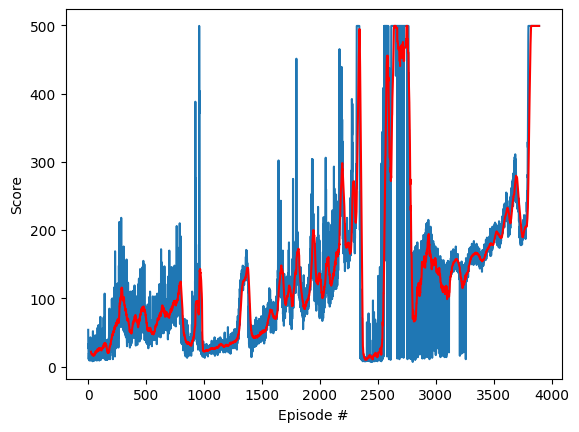

In [14]:
with init_random(gym.make('CartPole-v1')) as env:
    agent = Agent()
    scores = REINFORCE(env, agent)
plot_scores(scores)

  logger.warn(

  return F.softmax(acts)



MoviePy - Building file ./rl-video.gif with imageio.


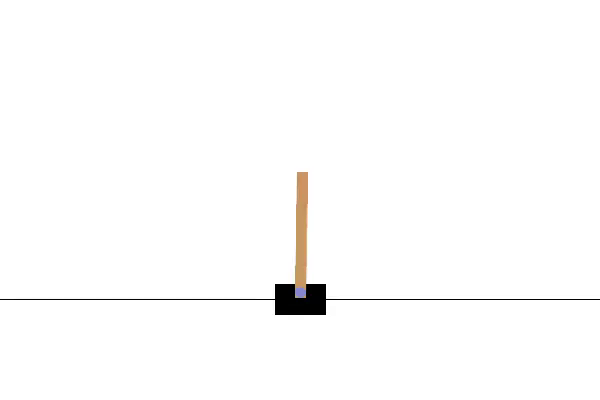

In [15]:
gym_simulation("CartPole-v1", agent)

## Improvements

### Use Future Rewards

First thing to notice is that we are using all rewards at every timestep. But really, we should only
consider future rewards: i.e., the rewards that are actually the consequences of our actions.

$$
g = \sum_t R_t^{future}\nabla_{\theta} log\pi_{\theta}(a_t | s_t)
$$

### Collect Multiple Trajectories

In every episode, we sample a single trajectory: the gradient update might not contain good data
about our policy and the stochastic updates might be very _noisy_. Learning happens because in the
long run we hope that all tiny signals accumulate and converge towards the optimal policy.

How do we reduce noise? The simplest strategy is to collect more trajectories (with the current
policy) at once! And Gymnasium vectorized environment `gym.vector.Env` serves exactly that purpose!

#### Normalize Rewards

When collecting multiple trajectories, a technique we can use is to normalize the rewards across
the various trajectories: which roughly picks half actions to encourage / discourage, and keeps the
gradient updates moderate.

$$
R_k \leftarrow \frac{R_k - \mu}{\sigma}
$$

The rewards distribution will also likely change during training, and a reward that might be good at
the beginning might actually signal a bad trajectory in late stages of training. Normalization helps
with such cases as well.

### Baseline Subtraction

The idea is to subtract to the reward a _baseline_ $b$, for example the average reward along all
trajectories (What if every trajectory has _always_ positive returns?). In this case, things that
are above average will push their probabilities to happen up while things below average will be
penalized.

$$
\theta_{k+1} = \theta_k - \alpha \sum_{t=0} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) [R(\tau) - b(s_t)]
$$

We can do this because on expectation this extra subtracted term will have zero effect (as long as
it does not depend on the action in _logprob_), but overall we'll get reduced variance (proof left
as exercise and/or you can find it in the resources).

#### Advantage Function

This value that we multiply with the log-probability to "reinforce" or "depress" the corresponding
actions is called the _advantage function_ and plays a critical role in state-of-the-art algorithms:

$$
A(*) = R(\tau) - b
$$

It measures how better the selected action does compared to the _average_ in the state.

In [87]:
# Note how we use a vectorized environment: gym.vector.VectorEnv!
def REINFORCE_v2(env: gym.vector.VectorEnv, agent, max_episodes=10_000, max_t=1_000, gamma=0.9999,
                 with_normalization=True, with_baseline=True):
    # Tracks the score for each episode. IMPORTANT: same remark as in REINFORCE above!
    scores = []
    # Loop for max_episodes.
    for i_episode in range(1, max_episodes + 1):
        # Store episode rewards, log probabilities, *AND* episode states for baseline computation!
        rewards, log_probs, states = ([], [], [])
        # Start the episode in the initial state.
        state, _ = env.reset()

        # TODO: Generate an episode following the policy. Copy the code above :) But...
        for t in range(max_t):
            # ...pay attention! We are now using a vectorized environment! Hence, to determine
            # episode completion we should check if `any()` is terminated or truncated!
            action, log_prob = agent.sample_action(state) # bs, bs x ACTION_SPACE
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(adjust_reward(state, reward))
            log_probs.append(log_prob)
            states.append(state)

            if terminated.any() or truncated.any(): break # EPS OVER

        # Compute discounted _future_ returns.
        # TODO: Compute the discounts and discounted rewards.
        discounts = torch.Tensor([gamma**i for i in range(len(log_probs))])
        # TODO: Pay attention to dimensionality of rewards (trajectory_len, n_envs), and how to
        #       broadcast discounts appropriately! Hint: use np.newaxis to add a dimension.
        rewards_envs = np.array(rewards) # eps_len, bs (n_envs)
        rewards_envs = torch.from_numpy(rewards_envs.T) # bs, eps_len
        computed_rewards = [] # array of tensor and needs to be stacked
        for idx in range(rewards_envs.shape[-1]):
            this_disc = discounts[idx:][None, :]# (1, rest_of_steps)
            this_rewards = rewards_envs[:, idx:] # (bs, rest_of_steps)
            scaled_this_rewards = this_rewards * this_disc # (bs, rest_of_steps)
            cum_sum_scaled_this_rewards = scaled_this_rewards.sum(-1).squeeze()# (bs)
            computed_rewards.append(cum_sum_scaled_this_rewards)

        # TODO: Compute the future_returns. Hint: consider cumulative sums in reverse order :)
        #       But again, pay attention in which axis to perform the cumulative sum!

        future_returns = torch.stack(computed_rewards).T # EVERYTHING IS A SCALER HERE... SO NO NEED TO WORRY ABOUT GRADIENTS

        # If the `with_baseline` argument flag is enabled, subtract a baseline to future returns.
        # breakpoint()

        if with_baseline:
            # TODO: Compute the state-dependent baseline. Feel free to explore different baselines!
            #       As a suggestion, use the product of the angle and angular velocity: it provides
            #       a proxy about how well we are contrasting the pole fall.
            #       Hint: use the tracked `states` to compute the time dependent baseline.
            baseline = np.asarray([states[t][:, 2] * states[t][:, 3] for t in range(len(rewards))]) # (eps_len, bs)
            baseline = torch.from_numpy(baseline).T # (bs, eps_len)
            # TODO: Subtract the baseline from future_returns.

            future_returns = future_returns - baseline

        # If the `with_normalization` argument flag is enabled, normalize future returns.
        # Note: normalize across multiple trajectories of the vectorized env for the same timestamp.
        if with_normalization:
            # TODO: Compute the mean. Hint: use np.mean on the proper axis.
            returns_mean = future_returns.mean(1)[:, None] # (bs, 1)
            # TODO: Compute the stdev. Hint: make sure the std is non zero; use np.std.
            returns_std = future_returns.mean(1)[:, None] # (bs, 1)
            # TODO: Normalize the future returns using mean and stdev.
            future_returns = (future_returns - returns_mean)/returns_std

        # TODO: Perform a learning step calling agent.learn(...)
        # copy() for negative strides :(
        #   https://discuss.pytorch.org/t/negative-strides-in-tensor-error/134287/2
        future_returns = future_returns.numpy()
        agent.learn(log_probs, future_returns)

        # Track scores and print statistics
        scores.append(t)
        avg_duration = np.mean(scores[-100:])
        if i_episode % 100 == 0:
            print(f'Episode {i_episode}\tAverage duration: {avg_duration:.2f}')
        if avg_duration >= 490.0: # Solved
            print(f'Environment solved at episode {i_episode}\tAvg. duration: {avg_duration:.2f}')
            break

    return scores

  return F.softmax(acts)



can't set attribute 'np_random'
Episode 100	Average duration: 11.23
Episode 200	Average duration: 9.65
Episode 300	Average duration: 8.79
Episode 400	Average duration: 8.04
Episode 500	Average duration: 8.37
Episode 600	Average duration: 30.84
Episode 700	Average duration: 74.10
Episode 800	Average duration: 205.00
Episode 900	Average duration: 413.81
Environment solved at episode 945	Avg. duration: 493.26


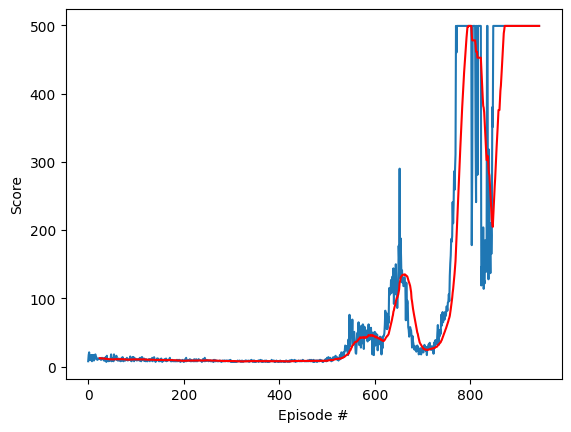

In [88]:
env = init_random(gym.make_vec('CartPole-v1', num_envs=5, vectorization_mode="sync"))
agent_v2 = Agent()
scores_v2 = REINFORCE_v2(env, agent_v2)
plot_scores(scores_v2)

  logger.warn(

  return F.softmax(acts)



MoviePy - Building file ./rl-video.gif with imageio.


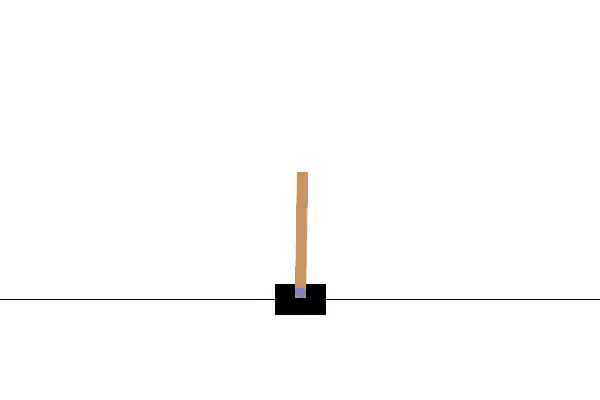

In [89]:
gym_simulation("CartPole-v1", agent_v2)

## What Can We Do Better?

There are other improvements that can be applied:

1. Actor-critic setup (with value function baseline) and advanced advantage estimation such as _GAE_
  will improve learning.
2. We are currently _discarding experiences_ after every learning step. That is because the policy
  effectively changes. But we'll see that with importance sampling we can iterate on the same data
  multiple times and learn in mini-batches!
3. Techniques such as "_trust region_" and "_loss clipping_" will help against degeneration and keep
  the policy learning along smooth gradient directions.

Once we put all of these in place... we'll have PPO!

## Appendix

### Meaning of Loss

Note that the loss function used in policy gradient methods doesn't have the same meaning of the
typical supervised learning setup. In particular, after that first step of gradient descent, there
is no more connection to performance - which is determined by the average return.

The loss function is only useful when evaluated at the current parameters to perform one step of
gradient ascent. After that it loses its meaning and it's value shouldn't be used as a metric for
performance.

More details on [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#id14).

### Performance Comparison

You can check how REINFORCE with future rewards + normalization + well crafted baseling performs
better than the vanilla REINFORCE.

Interesting to observe how we needed to tweak the reward function to reach these results: in fact,
formulating the reward function properly is one of the major challenges in RL and an area of open
research (e.g., curiosity driven agents).

As an exercise, try removing the adjustment of rewards in this notebook and just keep the original
Cart Pole `+1` per timestep reward. What's the effect on the algorithms' variants? Hint: check how
catastrophic learning is with normalization enabled!

In [90]:
import matplotlib.pyplot as plt

init_random()
base, norm, all = ([], [], [])
random_seeds = np.random.randint(3_141_592, size=10)
for seed in random_seeds:
    with init_random(gym.vector.make('CartPole-v1', num_envs=5), seed=int(seed)) as env:
        print('Future rewards only:')
        agent_v3 = Agent()
        scores_v3 = REINFORCE_v2(env, agent_v3, with_normalization=False, with_baseline=False)
        base.append(len(scores_v3))

    with init_random(gym.vector.make('CartPole-v1', num_envs=5), seed=int(seed)) as env:
        print('Future rewards + normalization:')
        agent_v3_b = Agent()
        scores_v3_b = REINFORCE_v2(env, agent_v3_b, with_normalization=True, with_baseline=False)
        norm.append(len(scores_v3_b))

    with init_random(gym.vector.make('CartPole-v1', num_envs=5), seed=int(seed)) as env:
        print('Future rewards + normalization + baseline:')
        agent_v3_bn = Agent()
        scores_v3_bn = REINFORCE_v2(env, agent_v3_bn, with_normalization=True, with_baseline=True)
        all.append(len(scores_v3_bn))
    print()

x = np.arange(len(norm))
plt.figure('Episode scores')
plt.plot(x, base, label='Future rewards')
plt.plot(x, norm, 'r', label='Future rewards + normalization')
plt.plot(x, all, 'g', label='Future rewards + normalization + baseline')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

AttributeError: module 'gymnasium.vector' has no attribute 'make'